# Out Paint

In [1]:
from tensorflow.python.keras.layers.convolutional import Conv2D, Convolution2D  #AtrousConvolution2D
from tensorflow.python.keras.layers import Activation, Dense, Input, Conv2DTranspose, Dense, Flatten
from tensorflow.python.keras.layers import ReLU, Dropout, Concatenate, BatchNormalization, Reshape
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.models import Model, model_from_json
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.layers.convolutional import UpSampling2D
import tensorflow.python.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import os
import numpy as np
import PIL
import cv2
import IPython.display
from IPython.display import clear_output
from datetime import datetime
from dataloader import Data, TestData

2022-10-21 19:02:08.064473: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# try:
#     from keras.contrib.layers.normalization import InstanceNormalization
# except Exception:
#     from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow_addons.layers import InstanceNormalization

/opt/tf/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
# Initialize dataloader
data = Data()
test_data = Data()

In [4]:
# Saves Model in every N minutes
TIME_INTERVALS = 2
SHOW_SUMMARY = True

INPUT_SHAPE = (256, 256, 3)
EPOCHS = 500
BATCH = 1

# 25% i.e 64 width size will be mask from both side
MASK_PERCENTAGE = .25

EPSILON = 1e-9
ALPHA = 0.0004

CHECKPOINT = "checkpoint/"
SAVED_IMAGES = "saved_images/"

## Models

### Discriminator

In [5]:
def dcrm_loss(y_true, y_pred):
    return -tf.reduce_mean(tf.math.log(tf.maximum(y_true, EPSILON)) + tf.math.log(tf.maximum(1. - y_pred, EPSILON)))

d_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENTAGE *2)), INPUT_SHAPE[2])
d_dropout = 0.25
DCRM_OPTIMIZER = Adam(0.0001, 0.5)

In [6]:
def d_build_conv(layer_input, filter_size, kernel_size=4, strides=2, activation='leakyrelu', dropout_rate=d_dropout, norm=True):
    c = Conv2D(filter_size, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
    if activation == 'leakyrelu':
        c = LeakyReLU(alpha=0.2)(c)
    if dropout_rate:
        c = Dropout(dropout_rate)(c)
    if norm == 'inst':
        c = InstanceNormalization()(c)
    return c


def build_discriminator():
    d_input = Input(shape=d_input_shape)
    d = d_build_conv(d_input, 32, 5,strides=2, norm=False)

    d = d_build_conv(d, 64, 5, strides=2)
    d = d_build_conv(d, 64, 5, strides=2)
    d = d_build_conv(d, 128, 5, strides=2)
    d = d_build_conv(d, 128, 5, strides=2)
    
    flat = Flatten()(d)
    fc1 = Dense(1024, activation='relu')(flat)
    d_output = Dense(1, activation='sigmoid')(fc1)
    
    return Model(d_input, d_output)

In [7]:
# Discriminator initialization
DCRM = build_discriminator()
DCRM.compile(loss=dcrm_loss, optimizer=DCRM_OPTIMIZER)
if SHOW_SUMMARY:
    DCRM.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 64, 32)       2432      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 64, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 64, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 32, 64)        51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 32, 64)       

2022-10-21 19:02:13.713769: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-10-21 19:02:15.577100: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:968] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-21 19:02:15.577140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 Laptop GPU computeCapability: 8.6
coreClock: 1.545GHz coreCount: 48 deviceMemorySize: 16.00GiB deviceMemoryBandwidth: 417.29GiB/s
2022-10-21 19:02:15.577158: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-10-21 19:02:15.578289: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-10-21 19:02:15.595693: I tensorflow/st

### Generator Model

In [8]:
def gen_loss(y_true, y_pred):
    G_MSE_loss = K.mean(K.square(y_pred - y_true))
    return G_MSE_loss - ALPHA * tf.reduce_mean(tf.math.log(tf.maximum(y_pred, EPSILON)))

g_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENTAGE *2)), INPUT_SHAPE[2])
g_dropout = 0.25
GEN_OPTIMIZER = Adam(0.001, 0.5)

In [9]:
def g_build_conv(layer_input, filter_size, kernel_size=4, strides=2, activation='leakyrelu', dropout_rate=g_dropout, norm='inst', dilation=1):
    c = Convolution2D(filter_size, kernel_size=kernel_size, strides=strides,dilation_rate=(dilation,dilation), padding='same')(layer_input)
    if activation == 'leakyrelu':
        c = ReLU()(c)
    if dropout_rate:
        c = Dropout(dropout_rate)(c)
    if norm == 'inst':
        c = InstanceNormalization()(c)
    return c


def g_build_deconv(layer_input, filter_size, kernel_size=3, strides=2, activation='relu', dropout=0):
    d = Conv2DTranspose(filter_size, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
    if activation == 'relu':
        d = ReLU()(d)
    return d


def build_generator():
    g_input = Input(shape=g_input_shape)
    
    g1 = g_build_conv(g_input, 64, 5, strides=1)
    g2 = g_build_conv(g1, 128, 4, strides=2)
    g3 = g_build_conv(g2, 256, 4, strides=2)

    g4 = g_build_conv(g3, 512, 4, strides=1)
    g5 = g_build_conv(g4, 512, 4, strides=1)
    
    g6 = g_build_conv(g5, 512, 4, strides=1, dilation=2)
    g7 = g_build_conv(g6, 512, 4, strides=1, dilation=4)
    g8 = g_build_conv(g7, 512, 4, strides=1, dilation=8)
    g9 = g_build_conv(g8, 512, 4, strides=1, dilation=16)
    
    g10 = g_build_conv(g9, 512, 4, strides=1)
    g11 = g_build_conv(g10, 512, 4, strides=1)
    
    g12 = g_build_deconv(g11, 256, 4, strides=2)
    g13 = g_build_deconv(g12, 128, 4, strides=2)
    
    g14 = g_build_conv(g13, 128, 4, strides=1)
    g15 = g_build_conv(g14, 64, 4, strides=1)
    
    g_output = Convolution2D(3, kernel_size=4, strides=(1,1), activation='tanh',padding='same', dilation_rate=(1,1))(g15)
    
    return Model(g_input, g_output)

In [10]:
# Generator Initialization
GEN = build_generator()
GEN.compile(loss=gen_loss, optimizer=GEN_OPTIMIZER)
if SHOW_SUMMARY:
    GEN.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 128, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 128, 64)      4864      
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 128, 64)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256, 128, 64)      0         
_________________________________________________________________
instance_normalization (Inst (None, 256, 128, 64)      128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 64, 128)      131200    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128, 64, 128)     

### Combined Model

In [11]:
IMAGE = Input(shape=g_input_shape)
DCRM.trainable = False
GENERATED_IMAGE = GEN(IMAGE)
CONF_GENERATED_IMAGE = DCRM(GENERATED_IMAGE)

COMBINED = Model(IMAGE, [CONF_GENERATED_IMAGE, GENERATED_IMAGE])
COMBINED.compile(loss=['mse', 'mse'], optimizer=GEN_OPTIMIZER)

### Masking and De-Masking

In [12]:
def mask_width(img):
    image = img.copy()
    height = image.shape[0]
    width = image.shape[1]
    new_width = int(width * MASK_PERCENTAGE)
    mask = np.ones([height, new_width, 3])
    missing_x = img[:, :new_width]
    missing_y = img[:, width - new_width:]
    missing_part = np.concatenate((missing_x, missing_y), axis=1)
    image = image[:, :width - new_width]
    image = image[:, new_width:]
    return image, missing_part


def get_masked_images(images):
    mask_images = []
    missing_images = []
    for image in images:
        mask_image, missing_image = mask_width(image)
        mask_images.append(mask_image)
        missing_images.append(missing_image)
    return np.array(mask_images), np.array(missing_images)


def get_demask_images(original_images, generated_images):
    demask_images = []
    for o_image, g_image in zip(original_images, generated_images):
        width = g_image.shape[1] // 2
        x_image = g_image[:, :width]
        y_image = g_image[:, width:]
        o_image = np.concatenate((x_image,o_image, y_image), axis=1)
        demask_images.append(o_image)
    return np.asarray(demask_images)

After masking
	Original Image			 a 		 b


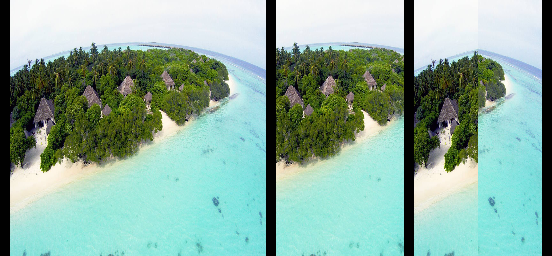

After desmasking: 'b/2' + a + 'b/2' 


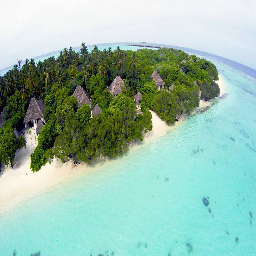

In [13]:
# Masking, Demasking example
# Note: IPython display gives false colors.
x = data.get_data(1)

# a will be the input and b will be the output for the model
a, b = get_masked_images(x)
border = np.ones([x[0].shape[0], 10, 3]).astype(np.uint8)
print('After masking')
print('\tOriginal Image\t\t\t a \t\t b')
image = np.concatenate((border, x[0],border,a[0],border, b[0], border), axis=1)
IPython.display.display(PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

print("After desmasking: 'b/2' + a + 'b/2' ")
c = get_demask_images(a,b)
IPython.display.display(PIL.Image.fromarray(cv2.cvtColor(c[0], cv2.COLOR_BGR2RGB)))

### Utilities
1. Save Model
2. Load Model
3. Save Image
4. Save Log

In [14]:
def save_model():
    global DCRM, GEN
    models = [DCRM, GEN]
    model_names = ['DCRM','GEN']

    for model, model_name in zip(models, model_names):
        model_path =  CHECKPOINT + "%s.json" % model_name
        weights_path = CHECKPOINT + "/%s.hdf5" % model_name
        options = {"file_arch": model_path, 
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])
    print("Saved Model")
    
    
def load_model():
    # Checking if all the model exists
    model_names = ['DCRM', 'GEN']
    files = os.listdir(CHECKPOINT)
    for model_name in model_names:
        if model_name+".json" not in files or\
           model_name+".hdf5" not in files:
            print("Models not Found")
            return
    global DCRM, GEN, COMBINED, IMAGE, GENERATED_IMAGE, CONF_GENERATED_IMAGE
    
    # load DCRM Model
    model_path = CHECKPOINT + "%s.json" % 'DCRM'
    weight_path = CHECKPOINT + "%s.hdf5" % 'DCRM'
    with open(model_path, 'r') as f:
        DCRM = model_from_json(f.read())
    DCRM.load_weights(weight_path)
    DCRM.compile(loss=dcrm_loss, optimizer=DCRM_OPTIMIZER)
    
    #load GEN Model
    model_path = CHECKPOINT + "%s.json" % 'GEN'
    weight_path = CHECKPOINT + "%s.hdf5" % 'GEN'
    with open(model_path, 'r') as f:
         GEN = model_from_json(f.read(), custom_objects={'InstanceNormalization': InstanceNormalization()})
    GEN.load_weights(weight_path)
    
    # Combined Model
    DCRM.trainable = False
    IMAGE = Input(shape=g_input_shape)
    GENERATED_IMAGE = GEN(IMAGE)
    CONF_GENERATED_IMAGE = DCRM(GENERATED_IMAGE)

    COMBINED = Model(IMAGE, [CONF_GENERATED_IMAGE, GENERATED_IMAGE])
    COMBINED.compile(loss=['mse', 'mse'], optimizer=GEN_OPTIMIZER)
    
    print("loaded model")
    
    
def save_image(epoch, steps):
    train_image = test_data.get_data(1)
    if train_image is None:
        train_image = test_data.get_data(1)
        
    test_image = data.get_data(1)
    if test_image is None:
        test_image = test_data.get_data(1)
    
    for nc, original in enumerate([train_image, test_image]):
        if nc:
            print("Predicting with train image")
        else:
            print("Predicting with test image")
            
        mask_image_original , missing_image = get_masked_images(original)
        mask_image = mask_image_original.copy()
        mask_image = mask_image / 127.5 - 1
        missing_image = missing_image / 127.5 - 1
        gen_missing = GEN.predict(mask_image)
        gen_missing = (gen_missing + 1) * 127.5
        gen_missing = gen_missing.astype(np.uint8)
        demask_image = get_demask_images(mask_image_original, gen_missing)

        mask_image = (mask_image + 1) * 127.5
        mask_image = mask_image.astype(np.uint8)

        border = np.ones([original[0].shape[0], 10, 3]).astype(np.uint8)

        file_name = str(epoch) + "_" + str(steps) + ".jpg"
        final_image = np.concatenate((border, original[0],border,mask_image_original[0],border, demask_image[0], border), axis=1)
        if not nc:
            cv2.imwrite(os.path.join(SAVED_IMAGES, file_name), final_image)
        final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
        print("\t1.Original image \t 2.Input \t\t 3. Output")
        IPython.display.display(PIL.Image.fromarray(final_image))
        print("image saved")


def save_log(log):
    with open('log.txt', 'a') as f:
        f.write("%s\n"%log)

## Train

In [15]:
def train():
    start_time = datetime.now()
    saved_time = start_time
    
    global MIN_D_LOSS, MIN_G_LOSS, CURRENT_D_LOSS, CURRENT_G_LOSS
    for epoch in range(1, EPOCHS):
        steps = 1
        test = None
        while True:
            original = data.get_data(BATCH)
            if original is None:
                break
            batch_size = original.shape[0]

            mask_image, missing_image = get_masked_images(original)
            mask_image = mask_image / 127.5 - 1
            missing_image = missing_image / 127.5 - 1

            # Train Discriminator
            gen_missing = GEN.predict(mask_image)

            real = np.ones([batch_size, 1])
            fake = np.zeros([batch_size, 1])
            
            d_loss_original = DCRM.train_on_batch(missing_image, real)
            d_loss_mask = DCRM.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_original, d_loss_mask)

            # Train Generator
            for i in range(2):
                g_loss = COMBINED.train_on_batch(mask_image, [real, missing_image])
                    
            log = "epoch: %d, steps: %d, DIS loss: %s, GEN loss: %s, Identity loss: %s" \
                                            %(epoch, steps, str(d_loss), str(g_loss[0]), str(g_loss[2]))
            print(log)
            save_log(log)
            steps += 1
            
            # Save model if time taken > TIME_INTERVALS
            current_time = datetime.now()
            difference_time = current_time - saved_time
            if difference_time.seconds >= (TIME_INTERVALS * 60):
                save_model()
                save_image(epoch, steps)
                saved_time = current_time
        clear_output()
        

In [16]:
load_model()

Models not Found


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2022-10-21 19:02:33.737392: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-21 19:02:33.741796: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3293685000 Hz
2022-10-21 19:02:33.742923: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3148760 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-10-21 19:02:33.742947: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-10-21 19:02:33.743824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1257] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-10-21 19:02:33.743843: I tensorflow/core/common_runtime/gpu/gpu_device.c

epoch: 1, steps: 1, DIS loss: 11.070220947265625, GEN loss: 1.0776361, Identity loss: 0.8121868
epoch: 1, steps: 2, DIS loss: 10.986947059631348, GEN loss: 1.3894098, Identity loss: 1.0671599
epoch: 1, steps: 3, DIS loss: 10.866142272949219, GEN loss: 1.1930681, Identity loss: 0.7719147
epoch: 1, steps: 4, DIS loss: 10.877034187316895, GEN loss: 0.9046893, Identity loss: 0.49346387
epoch: 1, steps: 5, DIS loss: 10.748950958251953, GEN loss: 0.7985913, Identity loss: 0.40131903
epoch: 1, steps: 6, DIS loss: 10.649531364440918, GEN loss: 0.8620994, Identity loss: 0.5048054
epoch: 1, steps: 7, DIS loss: 10.627239227294922, GEN loss: 0.99934053, Identity loss: 0.47578582
epoch: 1, steps: 8, DIS loss: 10.528435707092285, GEN loss: 0.937834, Identity loss: 0.49799198
epoch: 1, steps: 9, DIS loss: 10.567865371704102, GEN loss: 0.8810407, Identity loss: 0.34389243
epoch: 1, steps: 10, DIS loss: 10.52193546295166, GEN loss: 1.2561518, Identity loss: 0.45861232
epoch: 1, steps: 11, DIS loss: 10.

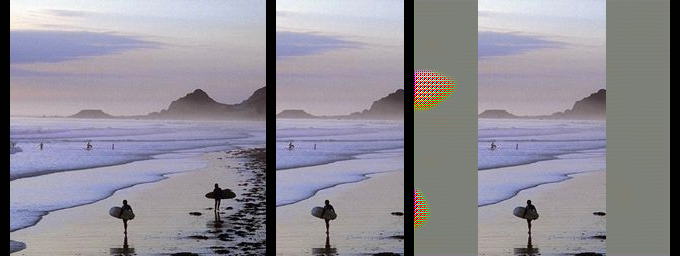

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


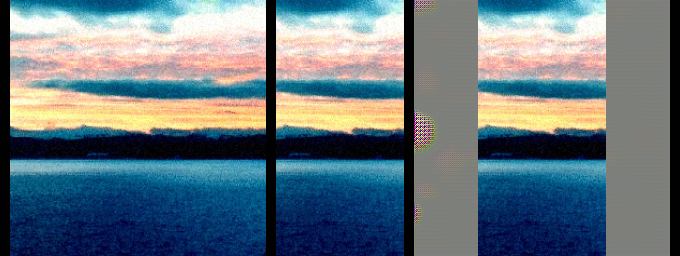

image saved
epoch: 1, steps: 21, DIS loss: 10.394213676452637, GEN loss: 1.4663591, Identity loss: 0.5123108
epoch: 1, steps: 22, DIS loss: 10.382255554199219, GEN loss: 1.3755972, Identity loss: 0.43667838
epoch: 1, steps: 23, DIS loss: 10.375506401062012, GEN loss: 1.3201342, Identity loss: 0.38646594
epoch: 1, steps: 24, DIS loss: 10.37022590637207, GEN loss: 1.175788, Identity loss: 0.22782204
epoch: 1, steps: 25, DIS loss: 10.372014045715332, GEN loss: 1.3472828, Identity loss: 0.39376834
epoch: 1, steps: 26, DIS loss: 10.369698524475098, GEN loss: 1.2738943, Identity loss: 0.30191392
epoch: 1, steps: 27, DIS loss: 10.37112808227539, GEN loss: 1.2691996, Identity loss: 0.3004135
epoch: 1, steps: 28, DIS loss: 10.370990753173828, GEN loss: 1.2587802, Identity loss: 0.28667837
epoch: 1, steps: 29, DIS loss: 10.370116233825684, GEN loss: 1.2832803, Identity loss: 0.29835778
epoch: 1, steps: 30, DIS loss: 10.366244316101074, GEN loss: 1.3820908, Identity loss: 0.3984794
epoch: 1, step

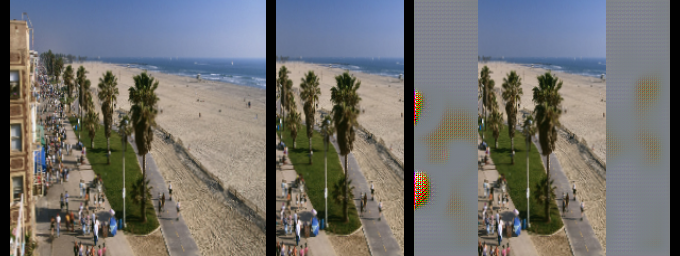

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


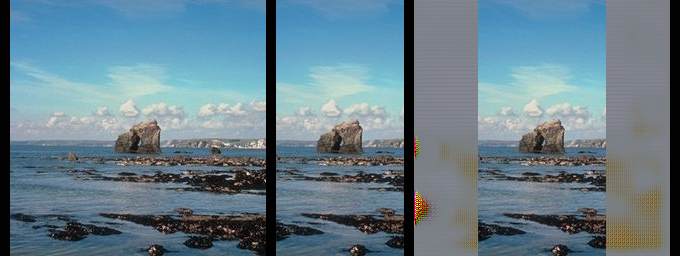

image saved
epoch: 1, steps: 42, DIS loss: 10.361647605895996, GEN loss: 1.591141, Identity loss: 0.59114116
epoch: 1, steps: 43, DIS loss: 10.36163330078125, GEN loss: 1.1645578, Identity loss: 0.16488712
epoch: 1, steps: 44, DIS loss: 10.36169719696045, GEN loss: 1.2665197, Identity loss: 0.26678237
epoch: 1, steps: 45, DIS loss: 10.361660957336426, GEN loss: 1.276659, Identity loss: 0.27680618
epoch: 1, steps: 46, DIS loss: 10.361684799194336, GEN loss: 1.500977, Identity loss: 0.5021759
epoch: 1, steps: 47, DIS loss: 10.361637115478516, GEN loss: 1.3446789, Identity loss: 0.3450639
epoch: 1, steps: 48, DIS loss: 10.361635208129883, GEN loss: 1.1812801, Identity loss: 0.1813257
epoch: 1, steps: 49, DIS loss: 10.361669540405273, GEN loss: 1.0977361, Identity loss: 0.09797448
epoch: 1, steps: 50, DIS loss: 10.36166000366211, GEN loss: 1.3734047, Identity loss: 0.3735861
epoch: 1, steps: 51, DIS loss: 10.361638069152832, GEN loss: 1.3651558, Identity loss: 0.36518383
epoch: 1, steps: 5

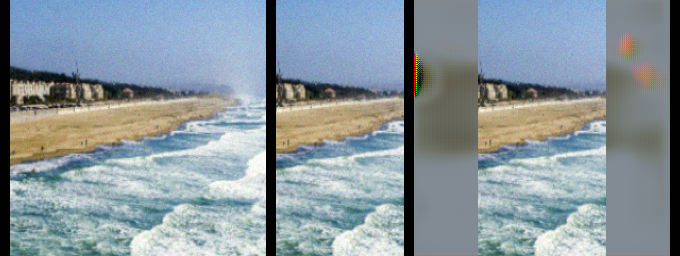

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


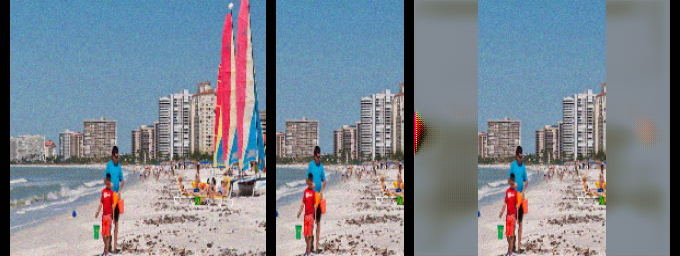

image saved
epoch: 1, steps: 62, DIS loss: 10.36163330078125, GEN loss: 1.3705834, Identity loss: 0.3705859
epoch: 1, steps: 63, DIS loss: 10.36163330078125, GEN loss: 1.232492, Identity loss: 0.23249222
epoch: 1, steps: 64, DIS loss: 10.36163330078125, GEN loss: 1.1352669, Identity loss: 0.13526687
epoch: 1, steps: 65, DIS loss: 10.36163330078125, GEN loss: 1.4736476, Identity loss: 0.4736476
epoch: 1, steps: 66, DIS loss: 10.36163330078125, GEN loss: 1.4389504, Identity loss: 0.43895057
epoch: 1, steps: 67, DIS loss: 10.36163330078125, GEN loss: 1.408765, Identity loss: 0.40876567
epoch: 1, steps: 68, DIS loss: 10.36163330078125, GEN loss: 1.2551564, Identity loss: 0.25516114
epoch: 1, steps: 69, DIS loss: 10.361634254455566, GEN loss: 1.3605553, Identity loss: 0.3605825
epoch: 1, steps: 70, DIS loss: 10.361637115478516, GEN loss: 1.5681607, Identity loss: 0.56822014
epoch: 1, steps: 71, DIS loss: 10.361641883850098, GEN loss: 1.130198, Identity loss: 0.13024496
epoch: 1, steps: 72, 

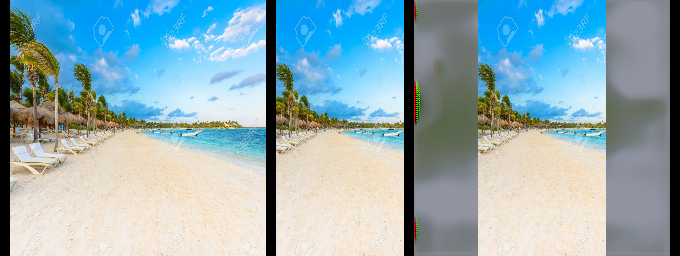

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


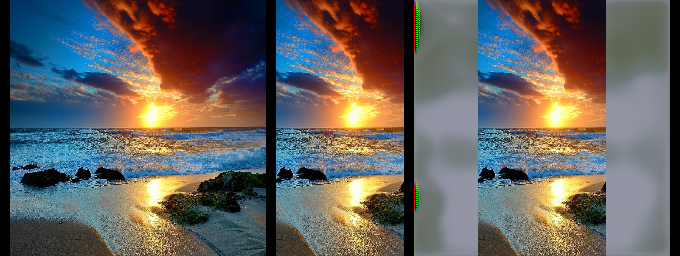

image saved
epoch: 1, steps: 82, DIS loss: 10.36163330078125, GEN loss: 1.3339286, Identity loss: 0.3339291
epoch: 1, steps: 83, DIS loss: 10.36163330078125, GEN loss: 1.3525977, Identity loss: 0.35259777
epoch: 1, steps: 84, DIS loss: 10.36163330078125, GEN loss: 1.2475181, Identity loss: 0.24751802
epoch: 1, steps: 85, DIS loss: 10.36163330078125, GEN loss: 1.1833822, Identity loss: 0.18338215
epoch: 1, steps: 86, DIS loss: 10.36163330078125, GEN loss: 1.2116945, Identity loss: 0.21169448
epoch: 1, steps: 87, DIS loss: 10.36163330078125, GEN loss: 1.5400302, Identity loss: 0.54003024
epoch: 1, steps: 88, DIS loss: 10.36163330078125, GEN loss: 1.8910136, Identity loss: 0.89101356
epoch: 1, steps: 89, DIS loss: 10.36163330078125, GEN loss: 1.2405094, Identity loss: 0.2405095
epoch: 1, steps: 90, DIS loss: 10.36163330078125, GEN loss: 1.2846992, Identity loss: 0.28471237
epoch: 1, steps: 91, DIS loss: 10.361635208129883, GEN loss: 1.2827171, Identity loss: 0.28272724
epoch: 1, steps: 92

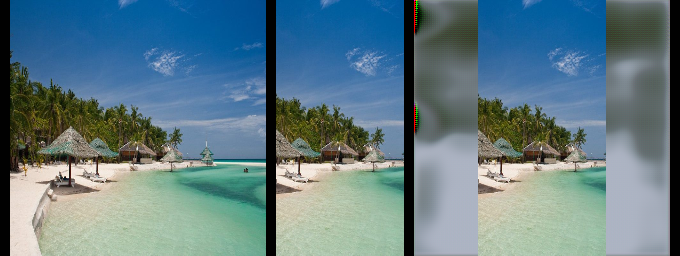

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


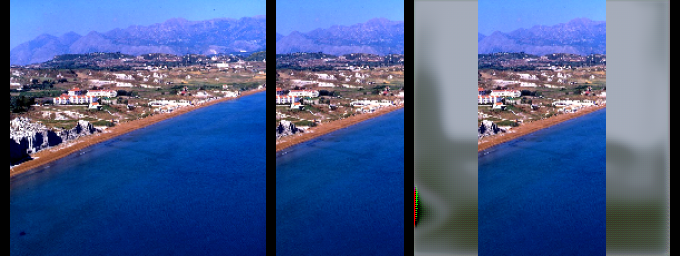

image saved
epoch: 1, steps: 102, DIS loss: 10.36163330078125, GEN loss: 1.7076819, Identity loss: 0.7076819
epoch: 1, steps: 103, DIS loss: 10.36163330078125, GEN loss: 1.2110981, Identity loss: 0.2110987
epoch: 1, steps: 104, DIS loss: 10.36163330078125, GEN loss: 1.1671112, Identity loss: 0.1671111
epoch: 1, steps: 105, DIS loss: 10.36163330078125, GEN loss: 1.3245519, Identity loss: 0.32455206
epoch: 1, steps: 106, DIS loss: 10.36163330078125, GEN loss: 1.1273456, Identity loss: 0.1273463
epoch: 1, steps: 107, DIS loss: 10.36163330078125, GEN loss: 1.352126, Identity loss: 0.35212597
epoch: 1, steps: 108, DIS loss: 10.36163330078125, GEN loss: 1.271877, Identity loss: 0.271877
epoch: 1, steps: 109, DIS loss: 10.36163330078125, GEN loss: 1.2792245, Identity loss: 0.2792245
epoch: 1, steps: 110, DIS loss: 10.36163330078125, GEN loss: 1.1460268, Identity loss: 0.14602679
epoch: 1, steps: 111, DIS loss: 10.36163330078125, GEN loss: 1.2200786, Identity loss: 0.22008026
epoch: 1, steps: 

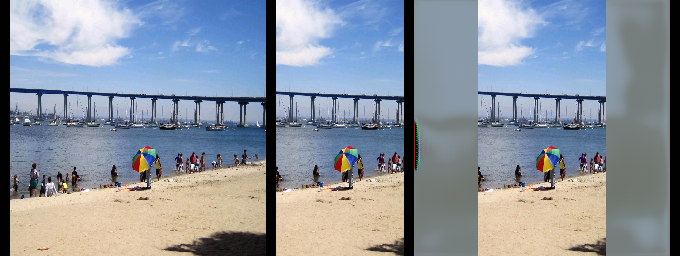

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


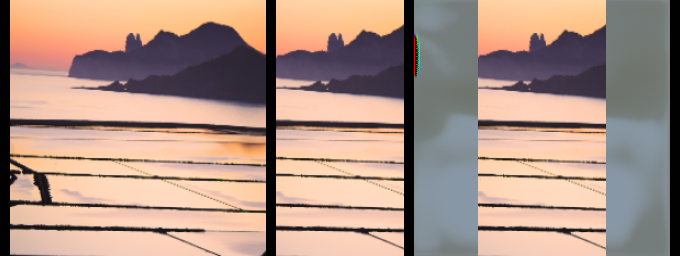

image saved
epoch: 1, steps: 122, DIS loss: 10.36163330078125, GEN loss: 1.3741568, Identity loss: 0.37416586
epoch: 1, steps: 123, DIS loss: 10.36163330078125, GEN loss: 1.3024502, Identity loss: 0.30245036
epoch: 1, steps: 124, DIS loss: 10.36163330078125, GEN loss: 1.2127146, Identity loss: 0.2127146
epoch: 1, steps: 125, DIS loss: 10.36163330078125, GEN loss: 1.3369277, Identity loss: 0.3369277
epoch: 1, steps: 126, DIS loss: 10.36163330078125, GEN loss: 1.3301883, Identity loss: 0.3301882
epoch: 1, steps: 127, DIS loss: 10.36163330078125, GEN loss: 1.2241364, Identity loss: 0.22413833
epoch: 1, steps: 128, DIS loss: 10.36163330078125, GEN loss: 1.2237204, Identity loss: 0.22372079
epoch: 1, steps: 129, DIS loss: 10.36163330078125, GEN loss: 1.1485269, Identity loss: 0.14852707
epoch: 1, steps: 130, DIS loss: 10.36163330078125, GEN loss: 1.2312837, Identity loss: 0.23128387
epoch: 1, steps: 131, DIS loss: 10.36163330078125, GEN loss: 1.2156894, Identity loss: 0.21568985
epoch: 1, s

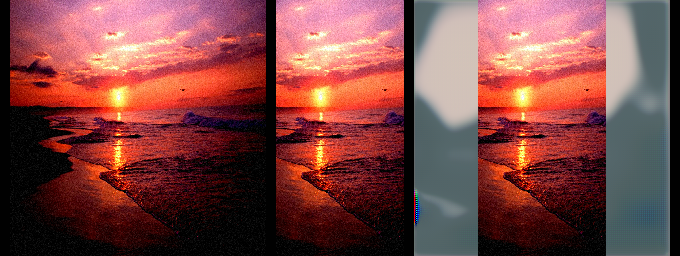

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


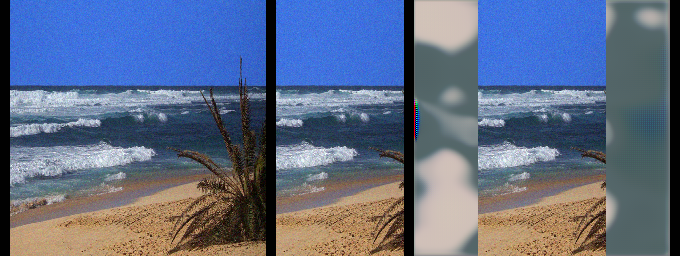

image saved
epoch: 1, steps: 143, DIS loss: 10.36163330078125, GEN loss: 1.3086671, Identity loss: 0.30866706
epoch: 1, steps: 144, DIS loss: 10.36163330078125, GEN loss: 1.1528461, Identity loss: 0.15284604
epoch: 1, steps: 145, DIS loss: 10.36163330078125, GEN loss: 1.2804773, Identity loss: 0.2804773
epoch: 1, steps: 146, DIS loss: 10.36163330078125, GEN loss: 1.2693315, Identity loss: 0.2693314
epoch: 1, steps: 147, DIS loss: 10.36163330078125, GEN loss: 1.5210342, Identity loss: 0.52103424
epoch: 1, steps: 148, DIS loss: 10.36163330078125, GEN loss: 1.2317778, Identity loss: 0.23177776
epoch: 1, steps: 149, DIS loss: 10.36163330078125, GEN loss: 1.2829471, Identity loss: 0.282947
epoch: 1, steps: 150, DIS loss: 10.36163330078125, GEN loss: 1.2529083, Identity loss: 0.25290835
epoch: 1, steps: 151, DIS loss: 10.36163330078125, GEN loss: 1.4492849, Identity loss: 0.4492849
epoch: 1, steps: 152, DIS loss: 10.36163330078125, GEN loss: 1.7721723, Identity loss: 0.77217233
epoch: 1, ste

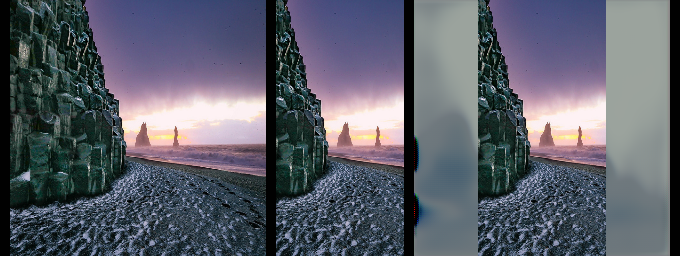

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


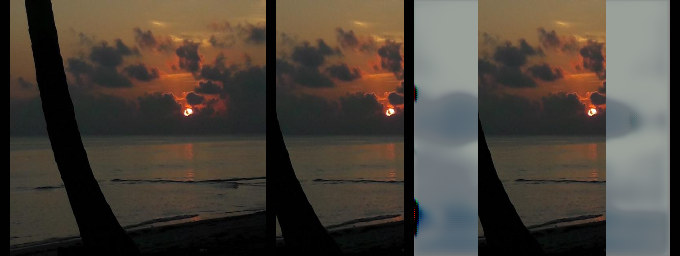

image saved
epoch: 1, steps: 164, DIS loss: 10.36163330078125, GEN loss: 1.1883883, Identity loss: 0.18838853
epoch: 1, steps: 165, DIS loss: 10.36163330078125, GEN loss: 1.3812404, Identity loss: 0.3812403
epoch: 1, steps: 166, DIS loss: 10.36163330078125, GEN loss: 1.2116045, Identity loss: 0.21160448
epoch: 1, steps: 167, DIS loss: 10.36163330078125, GEN loss: 1.2522073, Identity loss: 0.25220725
epoch: 1, steps: 168, DIS loss: 10.36163330078125, GEN loss: 1.4356378, Identity loss: 0.43563786
epoch: 1, steps: 169, DIS loss: 10.36163330078125, GEN loss: 1.2131703, Identity loss: 0.21317047
epoch: 1, steps: 170, DIS loss: 10.36163330078125, GEN loss: 1.1585704, Identity loss: 0.15857053
epoch: 1, steps: 171, DIS loss: 10.36163330078125, GEN loss: 1.2449301, Identity loss: 0.24493018
epoch: 1, steps: 172, DIS loss: 10.36163330078125, GEN loss: 1.2205544, Identity loss: 0.22055437
epoch: 1, steps: 173, DIS loss: 10.36163330078125, GEN loss: 1.1805798, Identity loss: 0.18057978
epoch: 1,

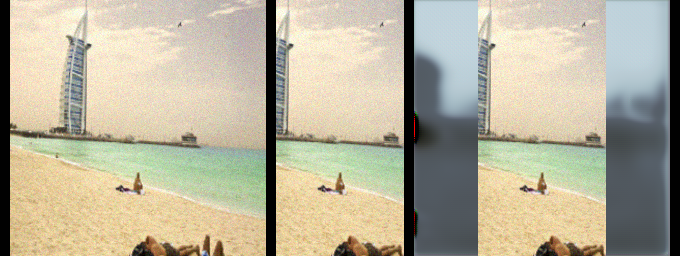

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


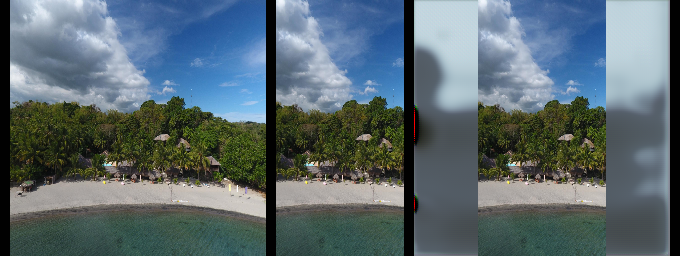

image saved
epoch: 1, steps: 184, DIS loss: 10.36163330078125, GEN loss: 1.2028844, Identity loss: 0.20288438
epoch: 1, steps: 185, DIS loss: 10.36163330078125, GEN loss: 1.1311144, Identity loss: 0.13111433
epoch: 1, steps: 186, DIS loss: 10.36163330078125, GEN loss: 1.3492041, Identity loss: 0.34920406
epoch: 1, steps: 187, DIS loss: 10.36163330078125, GEN loss: 1.4235365, Identity loss: 0.42353654
epoch: 1, steps: 188, DIS loss: 10.36163330078125, GEN loss: 1.2551377, Identity loss: 0.25513762
epoch: 1, steps: 189, DIS loss: 10.36163330078125, GEN loss: 1.4601588, Identity loss: 0.46015882
epoch: 1, steps: 190, DIS loss: 10.36163330078125, GEN loss: 1.141869, Identity loss: 0.14186898
epoch: 1, steps: 191, DIS loss: 10.36163330078125, GEN loss: 1.2510805, Identity loss: 0.25108057
epoch: 1, steps: 192, DIS loss: 10.36163330078125, GEN loss: 1.2181231, Identity loss: 0.21812311
epoch: 1, steps: 193, DIS loss: 10.36163330078125, GEN loss: 1.1375955, Identity loss: 0.1375955
epoch: 1, 

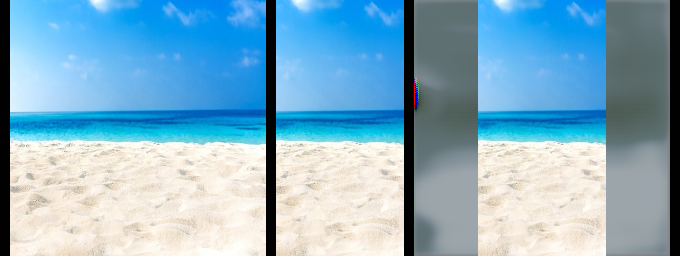

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


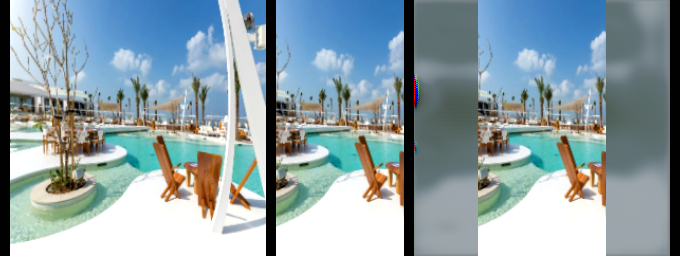

image saved
epoch: 1, steps: 204, DIS loss: 10.36163330078125, GEN loss: 1.3013413, Identity loss: 0.30134135
epoch: 1, steps: 205, DIS loss: 10.36163330078125, GEN loss: 1.1669028, Identity loss: 0.16690281
epoch: 1, steps: 206, DIS loss: 10.36163330078125, GEN loss: 1.1354557, Identity loss: 0.13545571
epoch: 1, steps: 207, DIS loss: 10.36163330078125, GEN loss: 1.2016271, Identity loss: 0.20162714
epoch: 1, steps: 208, DIS loss: 10.36163330078125, GEN loss: 1.308099, Identity loss: 0.30809897
epoch: 1, steps: 209, DIS loss: 10.36163330078125, GEN loss: 1.2348526, Identity loss: 0.23485252
epoch: 1, steps: 210, DIS loss: 10.36163330078125, GEN loss: 1.6134741, Identity loss: 0.6134742
epoch: 1, steps: 211, DIS loss: 10.36163330078125, GEN loss: 1.2486131, Identity loss: 0.24861307
epoch: 1, steps: 212, DIS loss: 10.36163330078125, GEN loss: 1.371283, Identity loss: 0.37128308
epoch: 1, steps: 213, DIS loss: 10.36163330078125, GEN loss: 1.1325485, Identity loss: 0.13254842
epoch: 1, s

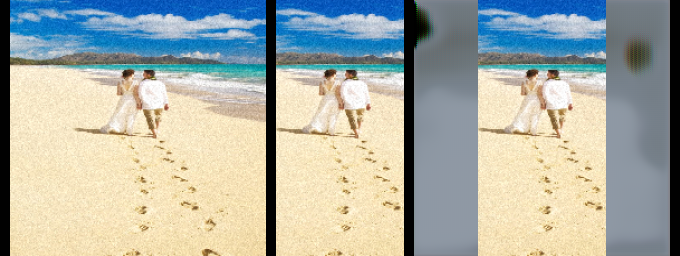

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


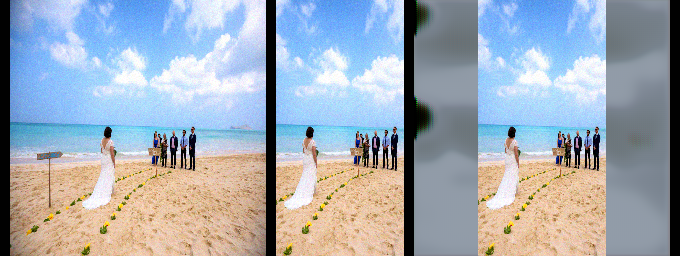

image saved
epoch: 1, steps: 225, DIS loss: 10.36163330078125, GEN loss: 1.3326944, Identity loss: 0.33269474
epoch: 1, steps: 226, DIS loss: 10.36163330078125, GEN loss: 1.2457035, Identity loss: 0.24570355
epoch: 1, steps: 227, DIS loss: 10.36163330078125, GEN loss: 1.3161001, Identity loss: 0.31610012
epoch: 1, steps: 228, DIS loss: 10.36163330078125, GEN loss: 1.2932305, Identity loss: 0.29323047
epoch: 1, steps: 229, DIS loss: 10.36163330078125, GEN loss: 1.3571537, Identity loss: 0.35715362
epoch: 1, steps: 230, DIS loss: 10.36163330078125, GEN loss: 1.2822354, Identity loss: 0.28223538
epoch: 1, steps: 231, DIS loss: 10.36163330078125, GEN loss: 1.2968081, Identity loss: 0.29680812
epoch: 1, steps: 232, DIS loss: 10.36163330078125, GEN loss: 1.2756221, Identity loss: 0.27562213
epoch: 1, steps: 233, DIS loss: 10.36163330078125, GEN loss: 1.3969123, Identity loss: 0.39691228
epoch: 1, steps: 234, DIS loss: 10.36163330078125, GEN loss: 1.2730973, Identity loss: 0.27309734
epoch: 1

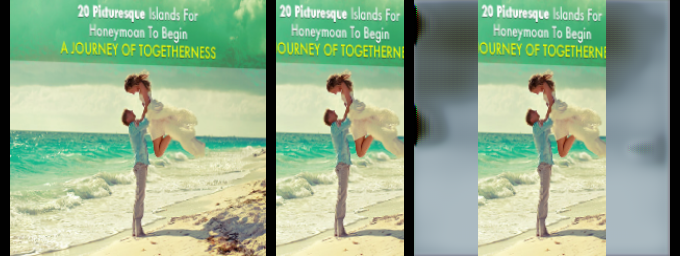

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


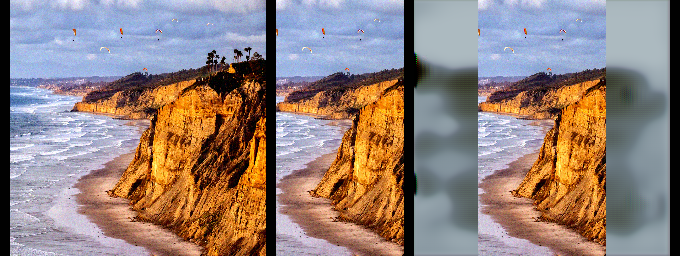

image saved
epoch: 1, steps: 245, DIS loss: 10.36163330078125, GEN loss: 1.1277869, Identity loss: 0.12778689
epoch: 1, steps: 246, DIS loss: 10.36163330078125, GEN loss: 1.302622, Identity loss: 0.30262196
epoch: 1, steps: 247, DIS loss: 10.36163330078125, GEN loss: 1.2834165, Identity loss: 0.28341645
epoch: 1, steps: 248, DIS loss: 10.36163330078125, GEN loss: 1.1459938, Identity loss: 0.14599383
epoch: 1, steps: 249, DIS loss: 10.36163330078125, GEN loss: 1.3645554, Identity loss: 0.36455542
epoch: 1, steps: 250, DIS loss: 10.36163330078125, GEN loss: 1.1405045, Identity loss: 0.14050451
epoch: 1, steps: 251, DIS loss: 10.36163330078125, GEN loss: 1.2731454, Identity loss: 0.27314538
epoch: 1, steps: 252, DIS loss: 10.36163330078125, GEN loss: 1.2206846, Identity loss: 0.22068462
epoch: 1, steps: 253, DIS loss: 10.36163330078125, GEN loss: 1.2328142, Identity loss: 0.2328142
epoch: 1, steps: 254, DIS loss: 10.36163330078125, GEN loss: 1.6302233, Identity loss: 0.6302234
epoch: 1, s

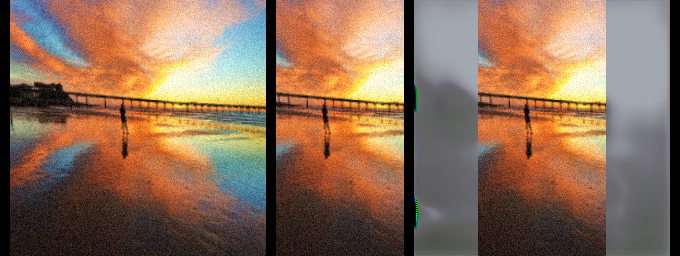

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


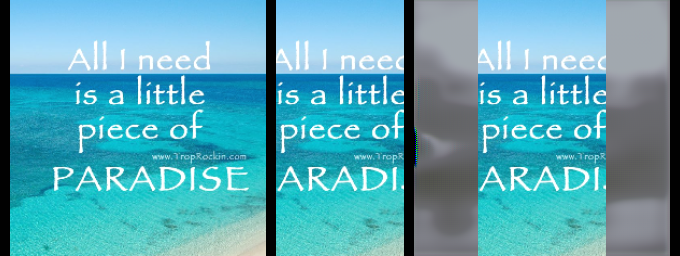

image saved
epoch: 1, steps: 266, DIS loss: 10.36163330078125, GEN loss: 1.2043355, Identity loss: 0.20433544
epoch: 1, steps: 267, DIS loss: 10.36163330078125, GEN loss: 1.0949944, Identity loss: 0.0949944
epoch: 1, steps: 268, DIS loss: 10.36163330078125, GEN loss: 1.239742, Identity loss: 0.23974207
epoch: 1, steps: 269, DIS loss: 10.36163330078125, GEN loss: 1.6858087, Identity loss: 0.68580866
epoch: 1, steps: 270, DIS loss: 10.36163330078125, GEN loss: 1.1924337, Identity loss: 0.19243374
epoch: 1, steps: 271, DIS loss: 10.36163330078125, GEN loss: 1.5686706, Identity loss: 0.56867063
epoch: 1, steps: 272, DIS loss: 10.36163330078125, GEN loss: 1.3242623, Identity loss: 0.32426226
epoch: 1, steps: 273, DIS loss: 10.36163330078125, GEN loss: 1.2123923, Identity loss: 0.21239233
epoch: 1, steps: 274, DIS loss: 10.36163330078125, GEN loss: 1.2041361, Identity loss: 0.20413613
epoch: 1, steps: 275, DIS loss: 10.36163330078125, GEN loss: 1.2952232, Identity loss: 0.29522318
epoch: 1, 

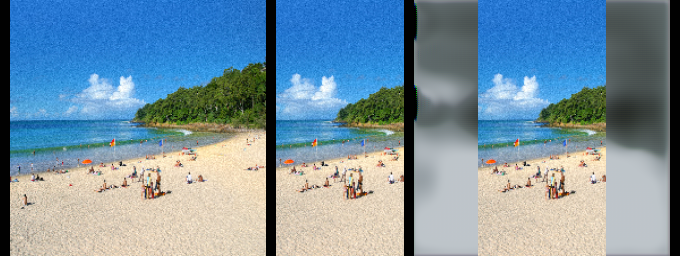

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


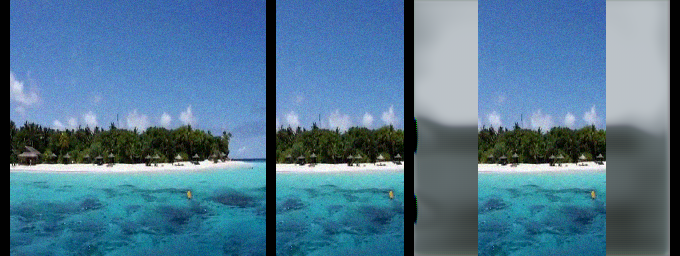

image saved
epoch: 1, steps: 286, DIS loss: 10.36163330078125, GEN loss: 1.2936398, Identity loss: 0.29363975
epoch: 1, steps: 287, DIS loss: 10.36163330078125, GEN loss: 1.1677872, Identity loss: 0.1677872
epoch: 1, steps: 288, DIS loss: 10.36163330078125, GEN loss: 1.2450753, Identity loss: 0.24507536
epoch: 1, steps: 289, DIS loss: 10.36163330078125, GEN loss: 1.184312, Identity loss: 0.18431199
epoch: 1, steps: 290, DIS loss: 10.36163330078125, GEN loss: 1.3133733, Identity loss: 0.3133733
epoch: 1, steps: 291, DIS loss: 10.36163330078125, GEN loss: 1.1476774, Identity loss: 0.14767745
epoch: 1, steps: 292, DIS loss: 10.36163330078125, GEN loss: 1.3507141, Identity loss: 0.35071412
epoch: 1, steps: 293, DIS loss: 10.36163330078125, GEN loss: 1.1586611, Identity loss: 0.1586611
epoch: 1, steps: 294, DIS loss: 10.36163330078125, GEN loss: 1.3162789, Identity loss: 0.31627887
epoch: 1, steps: 295, DIS loss: 10.36163330078125, GEN loss: 1.3345592, Identity loss: 0.33455926
epoch: 1, st

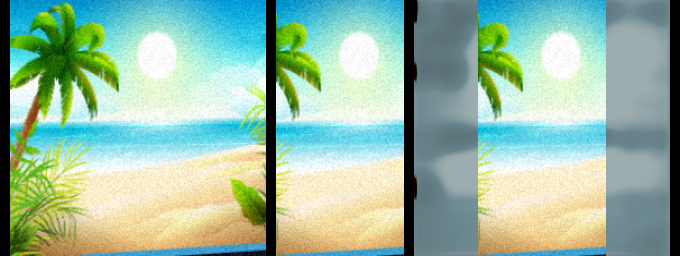

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


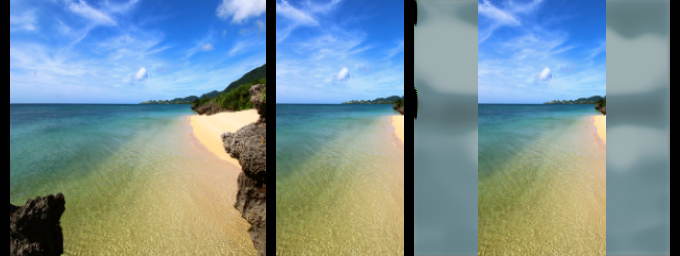

image saved
epoch: 1, steps: 306, DIS loss: 10.36163330078125, GEN loss: 1.3470423, Identity loss: 0.34704226
epoch: 1, steps: 307, DIS loss: 10.36163330078125, GEN loss: 1.3487136, Identity loss: 0.34871358
epoch: 1, steps: 308, DIS loss: 10.36163330078125, GEN loss: 1.2667882, Identity loss: 0.2667883
epoch: 1, steps: 309, DIS loss: 10.36163330078125, GEN loss: 1.0762224, Identity loss: 0.07622238
epoch: 1, steps: 310, DIS loss: 10.36163330078125, GEN loss: 1.210852, Identity loss: 0.21085203
epoch: 1, steps: 311, DIS loss: 10.36163330078125, GEN loss: 1.1602192, Identity loss: 0.16021919
epoch: 1, steps: 312, DIS loss: 10.36163330078125, GEN loss: 1.1559132, Identity loss: 0.15591323
epoch: 1, steps: 313, DIS loss: 10.36163330078125, GEN loss: 1.2604795, Identity loss: 0.26047942
epoch: 1, steps: 314, DIS loss: 10.36163330078125, GEN loss: 1.2218609, Identity loss: 0.22186095
epoch: 1, steps: 315, DIS loss: 10.36163330078125, GEN loss: 1.3310341, Identity loss: 0.33103415
epoch: 1, 

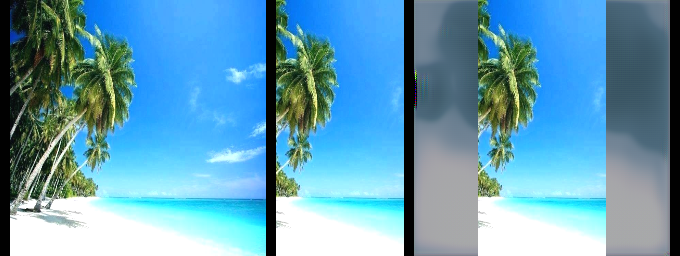

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


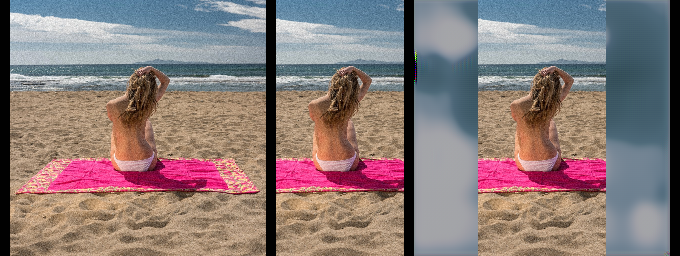

image saved
epoch: 1, steps: 326, DIS loss: 10.36163330078125, GEN loss: 1.286266, Identity loss: 0.28626597
epoch: 1, steps: 327, DIS loss: 10.36163330078125, GEN loss: 1.2392572, Identity loss: 0.23925722
epoch: 1, steps: 328, DIS loss: 10.36163330078125, GEN loss: 1.239135, Identity loss: 0.239135
epoch: 1, steps: 329, DIS loss: 10.36163330078125, GEN loss: 1.327174, Identity loss: 0.3271739
epoch: 1, steps: 330, DIS loss: 10.36163330078125, GEN loss: 1.2636006, Identity loss: 0.26360065
epoch: 1, steps: 331, DIS loss: 10.36163330078125, GEN loss: 1.3000045, Identity loss: 0.3000045
epoch: 1, steps: 332, DIS loss: 10.36163330078125, GEN loss: 1.4966216, Identity loss: 0.4966216
epoch: 1, steps: 333, DIS loss: 10.36163330078125, GEN loss: 1.3170468, Identity loss: 0.3170468
epoch: 1, steps: 334, DIS loss: 10.36163330078125, GEN loss: 1.4386423, Identity loss: 0.43864223
epoch: 1, steps: 335, DIS loss: 10.36163330078125, GEN loss: 1.2944055, Identity loss: 0.29440546
epoch: 1, steps: 

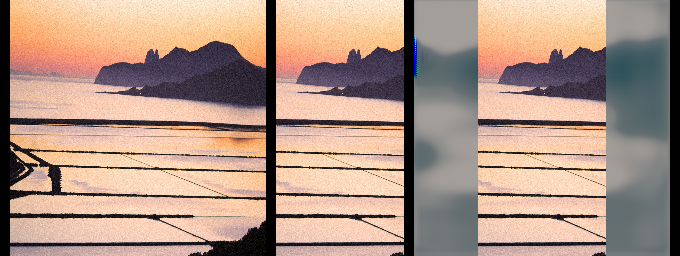

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


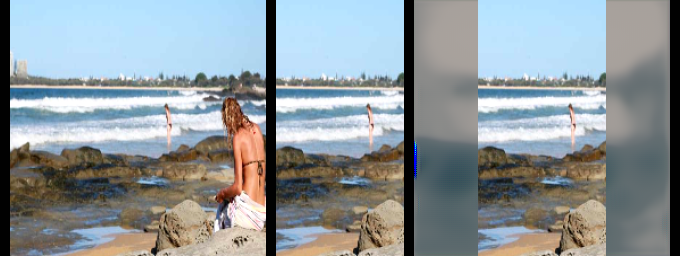

image saved
epoch: 1, steps: 346, DIS loss: 10.36163330078125, GEN loss: 1.115268, Identity loss: 0.11526816
epoch: 1, steps: 347, DIS loss: 10.36163330078125, GEN loss: 1.2738845, Identity loss: 0.27388543
epoch: 1, steps: 348, DIS loss: 10.36163330078125, GEN loss: 1.2853646, Identity loss: 0.28536457
epoch: 1, steps: 349, DIS loss: 10.36163330078125, GEN loss: 1.1503692, Identity loss: 0.15036923
epoch: 1, steps: 350, DIS loss: 10.36163330078125, GEN loss: 1.2942101, Identity loss: 0.29421005
epoch: 1, steps: 351, DIS loss: 10.36163330078125, GEN loss: 1.3257377, Identity loss: 0.32573774
epoch: 1, steps: 352, DIS loss: 10.36163330078125, GEN loss: 1.1596231, Identity loss: 0.1596232
epoch: 1, steps: 353, DIS loss: 10.36163330078125, GEN loss: 1.1018674, Identity loss: 0.10186747
epoch: 1, steps: 354, DIS loss: 10.36163330078125, GEN loss: 1.2335672, Identity loss: 0.23356724
epoch: 1, steps: 355, DIS loss: 10.36163330078125, GEN loss: 1.2798164, Identity loss: 0.27981642
epoch: 1, 

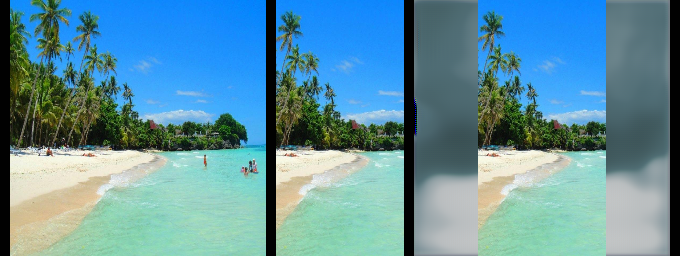

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


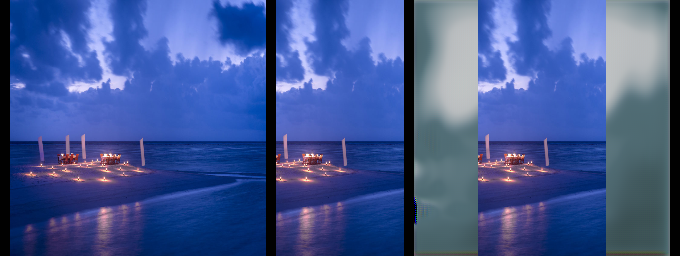

image saved
epoch: 1, steps: 366, DIS loss: 10.36163330078125, GEN loss: 1.2423186, Identity loss: 0.24231863
epoch: 1, steps: 367, DIS loss: 10.36163330078125, GEN loss: 1.5814328, Identity loss: 0.58143276
epoch: 1, steps: 368, DIS loss: 10.36163330078125, GEN loss: 1.3020436, Identity loss: 0.3020436
epoch: 1, steps: 369, DIS loss: 10.36163330078125, GEN loss: 1.2266843, Identity loss: 0.22668429
epoch: 1, steps: 370, DIS loss: 10.36163330078125, GEN loss: 1.2508068, Identity loss: 0.25080684
epoch: 1, steps: 371, DIS loss: 10.36163330078125, GEN loss: 1.2908673, Identity loss: 0.29086727
epoch: 1, steps: 372, DIS loss: 10.36163330078125, GEN loss: 1.5325415, Identity loss: 0.5325416
epoch: 1, steps: 373, DIS loss: 10.36163330078125, GEN loss: 1.145802, Identity loss: 0.14580199
epoch: 1, steps: 374, DIS loss: 10.36163330078125, GEN loss: 1.2422953, Identity loss: 0.24229524
epoch: 1, steps: 375, DIS loss: 10.36163330078125, GEN loss: 1.34751, Identity loss: 0.34751
epoch: 1, steps:

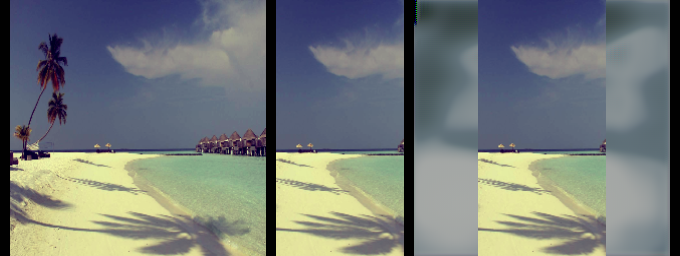

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


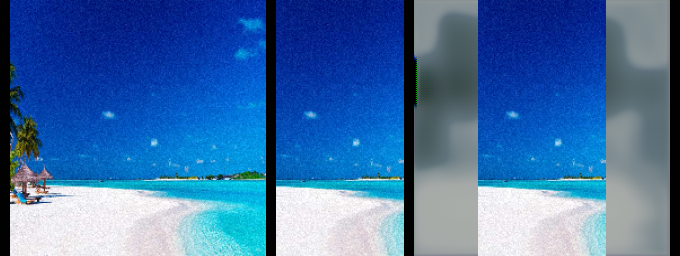

image saved
epoch: 1, steps: 386, DIS loss: 10.36163330078125, GEN loss: 1.3652492, Identity loss: 0.3652491
epoch: 1, steps: 387, DIS loss: 10.36163330078125, GEN loss: 1.7392068, Identity loss: 0.7392068
epoch: 1, steps: 388, DIS loss: 10.36163330078125, GEN loss: 1.3181319, Identity loss: 0.31813234
epoch: 1, steps: 389, DIS loss: 10.36163330078125, GEN loss: 1.1794765, Identity loss: 0.17947659
epoch: 1, steps: 390, DIS loss: 10.36163330078125, GEN loss: 1.3428477, Identity loss: 0.3428477
epoch: 1, steps: 391, DIS loss: 10.36163330078125, GEN loss: 1.2791762, Identity loss: 0.2791762
epoch: 1, steps: 392, DIS loss: 10.36163330078125, GEN loss: 1.3967421, Identity loss: 0.39674205
epoch: 1, steps: 393, DIS loss: 10.36163330078125, GEN loss: 1.1015184, Identity loss: 0.10151838
epoch: 1, steps: 394, DIS loss: 10.36163330078125, GEN loss: 1.2126932, Identity loss: 0.21269321
epoch: 1, steps: 395, DIS loss: 10.36163330078125, GEN loss: 1.2377621, Identity loss: 0.2377621
epoch: 1, ste

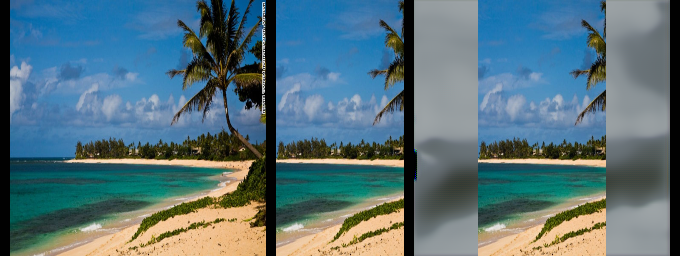

image saved
Predicting with train image
	1.Original image 	 2.Input 		 3. Output


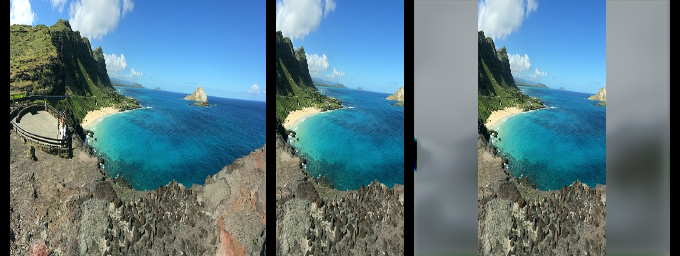

image saved
epoch: 1, steps: 406, DIS loss: 10.36163330078125, GEN loss: 1.3719769, Identity loss: 0.37197688
epoch: 1, steps: 407, DIS loss: 10.36163330078125, GEN loss: 1.4308145, Identity loss: 0.43081456
epoch: 1, steps: 408, DIS loss: 10.36163330078125, GEN loss: 1.2056679, Identity loss: 0.20566782
epoch: 1, steps: 409, DIS loss: 10.36163330078125, GEN loss: 1.2092028, Identity loss: 0.2092028
epoch: 1, steps: 410, DIS loss: 10.36163330078125, GEN loss: 1.1379976, Identity loss: 0.1379976
epoch: 1, steps: 411, DIS loss: 10.36163330078125, GEN loss: 1.2125711, Identity loss: 0.21257117
epoch: 1, steps: 412, DIS loss: 10.36163330078125, GEN loss: 1.5950863, Identity loss: 0.59508634
epoch: 1, steps: 413, DIS loss: 10.36163330078125, GEN loss: 1.4518199, Identity loss: 0.45181984
epoch: 1, steps: 414, DIS loss: 10.36163330078125, GEN loss: 1.2541561, Identity loss: 0.25415605
epoch: 1, steps: 415, DIS loss: 10.36163330078125, GEN loss: 1.3446507, Identity loss: 0.3446507
epoch: 1, s

In [17]:
train()

## Recursive paint

In [ ]:
load_model()

In [ ]:
def recursive_paint(image, factor=3):
    final_image = None
    gen_missing = None
    for i in range(factor):
        demask_image = None
        if i == 0:
            x, y = get_masked_images([image])
            gen_missing = GEN.predict(x)
            final_image = get_demask_images(x, gen_missing)[0]
        else:
            gen_missing = GEN.predict(gen_missing)
            final_image = get_demask_images([final_image], gen_missing)[0]
    return final_image
        

In [ ]:
images = data.get_data(1)
for i, image in enumerate(images):
    image = image / 127.5 - 1
    image = recursive_paint(image)
    image = (image + 1) * 127.5
    image = image.astype(np.uint8)
    path = 'recursive/'+str(i)+'.jpg'
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    IPython.display.display(PIL.Image.fromarray(image))

## Test from URL

In [ ]:
url = 'https://upload.wikimedia.org/wikipedia/commons/3/33/A_beach_in_Maldives.jpg'

file_name = os.path.basename(url)
import urllib.request
_ = urllib.request.urlretrieve(url, file_name)
print("Downloaded image")

image = cv2.imread(file_name)
image = cv2.resize(image, (256,256))
cropped_image = image[:, 65:193]
input_image = cropped_image / 127.5 - 1
input_image = np.expand_dims(input_image, axis=0)
print(input_image.shape)
predicted_image = GEN.predict(input_image)
predicted_image = get_demask_images(input_image, predicted_image)[0]
predicted_image = (predicted_image + 1) * 127.5
predicted_image = predicted_image.astype(np.uint8)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

print('original image')
IPython.display.display(PIL.Image.fromarray(image))
print('predicted image')
IPython.display.display(PIL.Image.fromarray(predicted_image))

os.remove(file_name)